# Bayesian scoring of sequence similarity
## Source: PhosphoSitePlus, sequences for all kinases and their targets

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import random
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from Bio import SeqIO
import math
from math import gamma, factorial
from scipy.special import loggamma, logsumexp


sns.set_style('ticks')

### global parameters

In [2]:
min_length = 100
np.random.seed(0)

## Easy visualization of protein sequences in jupyter notebook

In [3]:
#write your favorite color coding scheme

small = '#f4aa42'
hydrophobe = '#66b77b'
aromat = '#30f2f2'
polar = '#ff6df0'
negative = '#8682ff'
positive = '#ff4949'

aa_color_salma = {
    'R':positive,
    'K':positive,
    'H':positive,
    'E':negative,
    'D':negative,
    'F':aromat,
    'W':aromat,
    'Y':aromat,
    'I':hydrophobe,
    'L':hydrophobe,
    'M':hydrophobe,
    'V':hydrophobe
}


aa_color_lesk = {
    'G':small,
    'A':small,
    'S':small,
    'T':small,
    'C':hydrophobe,
    'V':hydrophobe,
    'I':hydrophobe,
    'L':hydrophobe,
    'P':hydrophobe,
    'M':hydrophobe,
    'F':aromat,
    'W':aromat,
    'Y':aromat,
    'N':polar,
    'Q':polar,
    'H':polar,
    'D':negative,
    'E':negative,
    'K':positive,
    'R':positive
}

aa_color_rasmol = {
    'D':negative,
    'E':negative,
    'K':positive,
    'R':positive,
    'F':'#3232aa',
    'Y':'#3232aa',
    'G':'#ebebeb',
    'A':'#c8c8c8',
    'H':'#8282d2',
    'C':'#e6e600',
    'M':'#e6e600',
    'S':'#fa9600',
    'T':'#fa9600',
    'N':'#00dcdc',
    'Q':'#00dcdc',
    'L':hydrophobe,
    'V':hydrophobe,
    'I':hydrophobe,
    'W':'#b45ab4',
    'P':'#dc9682',
}

In [4]:
#write out the sequences in html format according to the chosen coloring pattern

def display_seq(sequences, headers, color_code):
  
    text=''
    #text += 'body {font-family:monospace;font-size:12pt}'
    text += '<p style="font-family:monospace;font-size:12pt">'

    if color_code=='Lesk':
        aa_color=aa_color_lesk
        
        text += '<span style="background-color: %s">small</span><br />'%small
        text += '<span style="background-color: %s">polar</span><br />'%polar
        text += '<span style="background-color: %s">aromatic</span><br />'%aromat
        text += '<span style="background-color: %s">positive</span><br />'%positive
        text += '<span style="background-color: %s">negative</span><br />'%negative
        text += '<span style="background-color: %s">hydrophobe</span><br />'%hydrophobe
        text += '<br />'
        
    elif color_code=='RasMol':
        aa_color=aa_color_rasmol
        for key in aa_color_rasmol.keys():
            text += '<span style="background-color: %s">%s</span>'%(aa_color_rasmol[key],key)
        text += '<br /><br />'
        
    else:
        aa_color=aa_color_salma
        
        text += '<span style="background-color: %s">aromatic</span><br />'%aromat
        text += '<span style="background-color: %s">positive</span><br />'%positive
        text += '<span style="background-color: %s">negative</span><br />'%negative
        text += '<span style="background-color: %s">hydrophobe</span><br />'%hydrophobe
        text += '<br />'

    for i in range(len(sequences)):
        
        seq = sequences[i]
        header = headers[i]
        
        text += '%s<br />'%header
        
        for j,amino in enumerate(list(seq)):
            aa = amino.upper()
            if j%80==0:
                text += '<br />'
            text += '<span style="background-color: %s">%s</span>'%(aa_color.setdefault(aa, '#ffffff'),aa)
            
        text += '<br /><br />'

    text += '</p>'

    display(HTML(text))

## similarity scoring  helper functions

In [5]:
# each of the amino acids have a number code
amino_acids = {'a':0,'g':1,'v':2,'l':3,'i':4,'p':5,'f':6,'w':7,'m':8,'c':9,'n':10,
                    'q':11,'s':12,'t':13,'y':14,'d':15,'e':16,'r':17,'k':18,'h':19}

In [6]:
def fasta_parser(filename):
    with open(filename, 'r') as f:
        s = f.readlines()
    return list(map(str.rstrip, s))

In [7]:
def count_aa(seq):
    counts =[]
    for aa in amino_acids:
        counts.append(seq.count(aa))
    return np.array(counts)

In [8]:
def count_aa_frac(seq):
    counts = []
    l = len(seq)
    for aa in amino_acids:
        counts.append(seq.count(aa))
    return np.array([x/l for x in counts])

In [9]:
def count_aa_pair(seq):
    counts =[]
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            counts.append(seq.count(aa1+aa2))
    return np.array(counts)

In [10]:
def count_aa_pair_frac(seq):
    counts =[]
    l = len(seq)
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            counts.append(seq.count(aa1+aa2))
    return np.array([c/l for c in counts])

In [11]:
aa_hydrophobe = ['i','l','m','v']
aa_positive = ['k','r','h']
aa_negative = ['e','d']
aa_aromats = ['f','w','y']

def count_features(seq):
    h = 0
    for aa in aa_hydrophobe:
        h += seq.count(aa)
    p = 0
    for aa in aa_positive:
        p += seq.count(aa)
        
    n = 0
    for aa in aa_negative:
        n += seq.count(aa)
        
    a = 0
    for aa in aa_aromats:
        a += seq.count(aa)
        
    return np.array([h,a,p,n])

In [12]:
def count_features_frac(seq):
    l = len(seq)
    h = 0
    for aa in aa_hydrophobe:
        h += seq.count(aa)
    p = 0
    for aa in aa_positive:
        p += seq.count(aa)
        
    n = 0
    for aa in aa_negative:
        n += seq.count(aa)
    
    a = 0
    for aa in aa_aromats:
        a += seq.count(aa)
        
    return np.array([h/l,a/l,p/l,n/l])

# Jakub Look HERE

# --------->

In [13]:
def dirichlet_multinomial(x,alpha):
    '''
    where x is the count vector of amino-acids (20,1)
    alpha is the concentration hyper parameter (20,1)
    alpha_0 is the strength of the pseudo-counts (sum of alphas)
    
    calculations are in log space
    formula: https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution
    '''

    n = np.sum(x)
    alpha_0 = np.sum(alpha)
    
    log_probability = loggamma(n+1)+loggamma(alpha_0)-loggamma(n+alpha_0)

    for k in range(len(x)):
        log_probability += loggamma(x[k]+alpha[k])-loggamma(x[k]+1)-loggamma(alpha[k])
        
    return log_probability

In [14]:
def bayes_null(x,y,alpha):
    return dirichlet_multinomial(x,alpha)+dirichlet_multinomial(y,alpha)    

In [15]:
def bayes_model(x,y,alpha):
    dirich = dirichlet_multinomial(x+y,alpha)
    Lx = np.sum(x)
    Ly = np.sum(y)
    correction = loggamma(Lx+1) + loggamma(Ly+1) - loggamma(Lx+Ly+1)
    for k in range(len(x)):
        correction += loggamma(x[k]+y[k]+1) - loggamma(x[k]+1) -loggamma(y[k]+1)
    return correction + dirich

# <---------

In [16]:
def LL_alpha(proteome_feature_matrix, alpha_a, alpha_0):
    LL = 0
    alpha = alpha_0*alpha_a
    for xm in proteome_feature_matrix[0:1000]:
        Lx = np.sum(xm)
        LL += loggamma(Lx+1) + loggamma(alpha_0) - loggamma(Lx+alpha_0)
        for i in range(len(xm)):
            LL += loggamma(xm[i]+alpha[i]) - loggamma(xm[i]+1) -loggamma(alpha[i])
    return LL

### optional (doesn't work): fit alpha parameter based on disorder human proteome

In [17]:
if False:
    homo_seqs = fasta_parser('../human_proteome_disordered.fa')[1::2]

    #filter for longer sequences:
    homo_seqs = [seq for seq in homo_seqs if len(seq)>min_length]

    if False:
        counts_aa = [count_aa(seq) for seq in homo_seqs]
        counts_aa_pair = [count_aa_pair(seq) for seq in homo_seqs]

        average_frac_human_proteome = pd.DataFrame(counts_aa).mean(axis=0).values
        average_frac_human_proteome_pairs = pd.DataFrame(counts_aa_pair).mean(axis=0).values

        #alpha = alpha_0 * average_frac_human_proteome
        #alpha_pair = alpha_0 * average_frac_human_proteome_pairs

    LL = []
    for alpha in range(-10,10):
        LL.append(LL_alpha(counts_aa,average_frac_human_proteome, 10**alpha))

    plt.plot(range(-10,10),LL)

# ---------------------------------------------------------------

### get a correlation distribution for random pairs of proteins in the human proteome

In [18]:
#calculate alpha based on average frequencies of each feature

homo_seqs = fasta_parser('../human_proteome_disordered.fa')[1::2]

#filter for longer sequences:
homo_seqs = [seq for seq in homo_seqs if len(seq)>min_length]

to_execute = True
if to_execute:
    counts_aa = [count_aa_frac(seq) for seq in homo_seqs]
    counts_aa_pair = [count_aa_pair_frac(seq) for seq in homo_seqs]
    counts_feats = [count_features_frac(seq) for seq in homo_seqs]

    average_frac_human_proteome = pd.DataFrame(counts_aa).mean(axis=0).values
    average_frac_human_proteome_pairs = pd.DataFrame(counts_aa_pair).mean(axis=0).values
    average_frac_human_proteome_feats = pd.DataFrame(counts_feats).mean(axis=0).values
    
    
alpha_0 = 10
alpha = alpha_0 * average_frac_human_proteome
alpha_pair = alpha_0 * average_frac_human_proteome_pairs
alpha_feat = alpha_0 * average_frac_human_proteome_feats

# Example us

In [19]:
#calculate correlations for random pairs

np.random.seed(0)
sample_size = 1000

firsts = np.random.randint(low=0, high=len(homo_seqs), size=sample_size, dtype='l')
seconds = np.random.randint(low=0, high=len(homo_seqs), size=sample_size, dtype='l')

BF_homo_rand = []
BF_homo_rand_pairs = []

for i in range(sample_size):
    first_seq = homo_seqs[firsts[i]]
    second_seq = homo_seqs[seconds[i]]
    
    BN = bayes_null(count_aa(first_seq),count_aa(second_seq),alpha)
    BM = bayes_model(count_aa(first_seq),count_aa(second_seq),alpha)    
    BF_homo_rand.append(BM-BN)
    
    BN = bayes_null(count_aa_pair(first_seq),count_aa_pair(second_seq),alpha_pair)
    BM = bayes_model(count_aa_pair(first_seq),count_aa_pair(second_seq),alpha_pair)    
    BF_homo_rand_pairs.append(BM-BN)

(-151.34817294138637, 226.6327460624782)

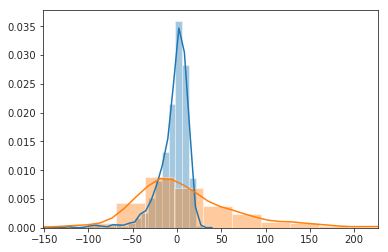

In [20]:
sns.set_style('ticks')
sns.distplot(BF_homo_rand, bins=100)
sns.distplot(BF_homo_rand_pairs)
plt.xlim(np.percentile(BF_homo_rand_pairs,1),np.percentile(BF_homo_rand_pairs,99))

### TEST BAYES: summation of probabilities

In [21]:
if False:
    seqs = []
    for i in range(20):
        for j in range(i,20):
             seqs.append(list(amino_acids.keys())[i]+list(amino_acids.keys())[j])

    seqs = []
    for aa1 in amino_acids:
        seqs.append(aa1)

    alpha_0 = 1

    average_frac_human_proteome = pd.DataFrame([count_aa_frac(seq) for seq in homo_seqs],columns=amino_acids).mean(axis=0).values

    alpha = alpha_0 * average_frac_human_proteome

    dirichlet = []
    for seq in seqs:
        dirichlet.append(dirichlet_multinomial(count_aa(seq),alpha))
    dirichlet = np.array(dirichlet)
    np.exp(logsumexp(dirichlet))

    #calculate composition correlations for all pairs

    xx_BF = []
    for seq1 in seqs:
        for seq2 in seqs:
            first_seq = count_aa(seq1)
            second_seq = count_aa(seq2)

            BN = bayes_null(first_seq,second_seq,alpha)
            xx_BF.append(BN)
    xx_BF = np.array(xx_BF)

    np.exp(logsumexp(xx_BF))

    sns.set_style('ticks')
    #h = plt.hist(corr_homo_rand, bins=30, density=True)
    sns.distplot(xx_BF)

# ---------------------------------------------------------------

## load the dataset for kinase target interactions

In [29]:
meta_table = pd.read_csv('Kinase_Substrate_Dataset_PhosphoSitePlus.txt', sep='\t')
#meta_table.head(4)

#### I fed protein IDs in Uniprot and extracted fasta sequences. These sequences were processed by IUPred for disorder prediction.

In [30]:
targets_seq_list = fasta_parser('Targets_PhosphoSitePlus_disordered.fa')
kinases_seq_list = fasta_parser('Kinases_PhosphoSitePlus_disordered.fa')

keys = [x.split('|')[1] for x in targets_seq_list[0::2]]
targets_seq = dict(zip(keys, targets_seq_list[1::2]))

keys = [x.split('|')[1] for x in kinases_seq_list[0::2]]
kinases_seq = dict(zip(keys, kinases_seq_list[1::2]))

#### Add the predicted disorder sequences in meta table

In [32]:
#make kinase sequence vector
mt_kinase = []
for acc_id in meta_table.KIN_ACC_ID:
    try:
        seq = kinases_seq[acc_id]
    except:
        seq = ''
    mt_kinase.append(seq)

#make target sequence vector
mt_target = []
for acc_id in meta_table.SUB_ACC_ID:
    try:
        seq = targets_seq[acc_id]
    except:
        seq = ''
    mt_target.append(seq)

meta_table['kinase_disorder'] = mt_kinase
meta_table['target_disorder'] = mt_target

meta_table_reduced = meta_table.loc[:,['KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE', 'SUB_ACC_ID', 'kinase_disorder', 'target_disorder']]
meta_table_reduced = meta_table_reduced.loc[:,['KINASE', 'SUBSTRATE', 'KIN_ORGANISM', 'kinase_disorder', 'target_disorder', 'kinase_length', 'target_length', 'compo_correlation', 'pair_compo_correlation']]

meta_table_reduced.head(5)

,KINASE,SUBSTRATE,KIN_ORGANISM,kinase_disorder,target_disorder,kinase_length,target_length,compo_correlation,pair_compo_correlation
0,PAK2,MEK1,rat,msdngeledkppappvrmsstifstggkdplsanhslkplpsvpee...,mpkkkptpiqlnpapdgsavngtssaetnlealqkklasi,NaN,NaN,NaN,NaN
1,PAK2,PRKD1,rat,msdngeledkppappvrmsstifstggkdplsanhslkplpsvpee...,ingellspgaesdvvmeegsddndsernsglmddmdeamvqdtema...,NaN,NaN,NaN,NaN
2,PAK2,prolactin,rat,msdngeledkppappvrmsstifstggkdplsanhslkplpsvpee...,,NaN,NaN,NaN,NaN
3,PAK2,prolactin,rat,msdngeledkppappvrmsstifstggkdplsanhslkplpsvpee...,,NaN,NaN,NaN,NaN
4,HRI,eIF2-alpha,human,mqggnsgvrkreeegdgagavaappaidfpaegpdpeydesdvpae...,gvfnvqmepkvvtdtdetelarqlerlerenaevdgdddaeemeakaed,NaN,NaN,NaN,NaN


### Concatenate with RegPhos dataset

In [47]:
regphos = pd.read_csv('RegPhos/RegPhos_correlation_pairs.txt', sep='\t')

regphos['KIN_ORGANISM'] = ['human']*len(regphos)
regphos= regphos.loc[:,['catalytic kinase', 'ID', 'KIN_ORGANISM', 'kinase_disorder', 'target_disorder', 'kinase_length', 'target_length','compo_correlation', 'pair_compo_correlation']]

regphos.head(4)

,catalytic kinase,ID,KIN_ORGANISM,kinase_disorder,target_disorder,kinase_length,target_length,compo_correlation,pair_compo_correlation
0,PTK2,FAK1_HUMAN,human,kegeralpsipklansekqgmrthavsvsetddyaeiideedtytm...,maaayldpnlnhtpnsstkthlgtgmkegeralpsipklansekqg...,314,340,0.981516,0.969117
1,TTBK1,TAU_HUMAN,human,eafdwekagtdallstststppqqntrqtaamfgvvnvtpvpgdll...,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,1016,758,0.875753,0.647054
2,PHKA1,KPB1_HUMAN,human,sngghplgidlmspsfmspgtsmtpssgsfpsaydqqsskdsrqgqwq,eikqvefrrlsisaesqspgtsmtpssgsfpsaydqqsskdsrqgqwq,48,48,0.527860,0.633167
3,SLK,TAOK3_HUMAN,human,snkpireliaeakaevteevedgkeedeeeetenslpipaskrass...,qyrkmkkilfqetrngplnesqedeedsehgtslnremdslgsnhs...,892,462,0.850152,0.569531


In [48]:
regphos.columns = ['KINASE', 'SUBSTRATE', 'KIN_ORGANISM', 'kinase_disorder', 'target_disorder', 'kinase_length', 'target_length',
       'compo_correlation', 'pair_compo_correlation']
regphos.head(4)

,KINASE,SUBSTRATE,KIN_ORGANISM,kinase_disorder,target_disorder,kinase_length,target_length,compo_correlation,pair_compo_correlation
0,PTK2,FAK1_HUMAN,human,kegeralpsipklansekqgmrthavsvsetddyaeiideedtytm...,maaayldpnlnhtpnsstkthlgtgmkegeralpsipklansekqg...,314,340,0.981516,0.969117
1,TTBK1,TAU_HUMAN,human,eafdwekagtdallstststppqqntrqtaamfgvvnvtpvpgdll...,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,1016,758,0.875753,0.647054
2,PHKA1,KPB1_HUMAN,human,sngghplgidlmspsfmspgtsmtpssgsfpsaydqqsskdsrqgqwq,eikqvefrrlsisaesqspgtsmtpssgsfpsaydqqsskdsrqgqwq,48,48,0.527860,0.633167
3,SLK,TAOK3_HUMAN,human,snkpireliaeakaevteevedgkeedeeeetenslpipaskrass...,qyrkmkkilfqetrngplnesqedeedsehgtslnremdslgsnhs...,892,462,0.850152,0.569531


In [49]:
meta_table_reduced = meta_table_reduced.append(regphos)

len(meta_table_reduced)

18287

### filter for proteins with sufficient disorder

In [33]:
len(meta_table_reduced)

17683

In [34]:
meta_table_reduced = meta_table_reduced.drop_duplicates()
len(meta_table_reduced)

9937

In [35]:
meta_table_reduced['kinase_length'] = [len(x) for x in meta_table_reduced.kinase_disorder]
meta_table_reduced['target_length'] = [len(x) for x in meta_table_reduced.target_disorder]

meta_table_reduced = meta_table_reduced.query('kinase_length>%s'%min_length).query('target_length>%s'%min_length)
meta_table_reduced = meta_table_reduced.query('KINASE!=SUBSTRATE')
meta_table_reduced = meta_table_reduced.loc[meta_table_reduced.KIN_ORGANISM == 'human']

len(meta_table_reduced)

738

# -------------------------------------------------------
### [optional] Combine targets for better statistical power

In [36]:
len(meta_table_reduced.KINASE.unique())

138

In [37]:
comb_targets = False

if comb_targets:    
    meta_table_comb = pd.DataFrame(columns=['KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE', 'SUB_ACC_ID', 'kinase_disorder', 'target_disorder'])


    for i,kinase in enumerate(meta_table_reduced.KINASE.unique()):
        kinase_do = meta_table_reduced.loc[meta_table_reduced.KINASE==kinase].kinase_disorder.values[0]
        sub_do = ''.join(meta_table_reduced.loc[meta_table_reduced.KINASE==kinase].target_disorder.values)
        sub_names = '_'.join(meta_table_reduced.loc[meta_table_reduced.KINASE==kinase].SUBSTRATE.values)
        meta_table_comb.loc[i]=[kinase,'-','human',sub_names,'-',kinase_do,sub_do]   

    #meta_table_reduced = meta_table_comb

    meta_table_comb.head()
    kinase_targets_dict = {}
    for i,kinase in enumerate(meta_table_comb.KINASE):
        kinase_targets_dict[kinase] = meta_table_comb.SUBSTRATE.values[i].split('_')

    meta_table_comb.SUBSTRATE.values[0]

# -------------------------------------------------------
## Bayesian Modeling

### Randomly selected pairs from kinases and targets

In [38]:
if comb_targets: 
    homo_seqs = np.unique(list(meta_table_comb.kinase_disorder.values) + list(meta_table_comb.target_disorder.values))
    print(len(homo_seqs))

### background set

In [39]:
#choose background set
proteome_as_bg = False

if proteome_as_bg:
    bg_set = homo_seqs
else:
    bg_set = np.unique(list(meta_table_reduced.kinase_disorder.values) + list(meta_table_reduced.target_disorder.values))
    
counts_aa = [count_aa_frac(seq) for seq in bg_set]
counts_aa_pair = [count_aa_pair_frac(seq) for seq in bg_set]
counts_feats = [count_features_frac(seq) for seq in bg_set]

average_frac_human_proteome = pd.DataFrame(counts_aa).mean(axis=0).values
average_frac_human_proteome_pairs = pd.DataFrame(counts_aa_pair).mean(axis=0).values
average_frac_human_proteome_feats = pd.DataFrame(counts_feats).mean(axis=0).values

alpha_0 = 1
alpha = alpha_0 * average_frac_human_proteome
alpha_pair = alpha_0 * average_frac_human_proteome_pairs
alpha_feat = alpha_0 * average_frac_human_proteome_feats

### get a correlation distribution for random pairs of proteins

#calculate composition correlations for random pairs
np.random.seed(0)
sample_size = 1000
firsts = np.random.randint(low=0, high=len(bg_set), size=sample_size, dtype='l')
seconds = np.random.randint(low=0, high=len(bg_set), size=sample_size, dtype='l')

BF_homo_rand = []
BF_homo_rand_pairs = []
BF_homo_rand_feats = []

for i in range(sample_size):
    first_seq = bg_set[firsts[i]]
    second_seq = bg_set[seconds[i]]

    BN = bayes_null(count_aa(first_seq),count_aa(second_seq),alpha)
    BM = bayes_model(count_aa(first_seq),count_aa(second_seq),alpha)    
    BF_homo_rand.append(BM-BN)

    BN = bayes_null(count_aa_pair(first_seq),count_aa_pair(second_seq),alpha_pair)
    BM = bayes_model(count_aa_pair(first_seq),count_aa_pair(second_seq),alpha_pair)    
    BF_homo_rand_pairs.append(BM-BN)

    BN = bayes_null(count_features(first_seq),count_features(second_seq),alpha_feat)
    BM = bayes_model(count_features(first_seq),count_features(second_seq),alpha_feat)    
    BF_homo_rand_feats.append(BM-BN)

### correlation on kinase-target pairs 

In [40]:
compo_kinases = {}
compo_targets = {}

compo_kinases_pair = {}
compo_targets_pair = {}

compo_kinases_feats = {}
compo_targets_feats = {}

for i in range(len(meta_table_reduced)):
    compo_kinases[i] = count_aa(meta_table_reduced.iat[i,3])
    compo_targets[i] = count_aa(meta_table_reduced.iat[i,4])
    
    compo_kinases_pair[i] = count_aa_pair(meta_table_reduced.iat[i,3])
    compo_targets_pair[i] = count_aa_pair(meta_table_reduced.iat[i,4])
    
    compo_kinases_feats[i] = count_features(meta_table_reduced.iat[i,3])
    compo_targets_feats[i] = count_features(meta_table_reduced.iat[i,4])

In [41]:
BF_real = []
BF_real_pairs = [] 
BF_real_feats = []

for i in range(len(meta_table_reduced)):
    BN = bayes_null(compo_targets[i],compo_kinases[i],alpha)
    BM = bayes_model(compo_targets[i],compo_kinases[i],alpha)    
    BF_real.append(BM-BN)
        
    BN = bayes_null(compo_targets_pair[i],compo_kinases_pair[i],alpha_pair)
    BM = bayes_model(compo_targets_pair[i],compo_kinases_pair[i],alpha_pair)    
    BF_real_pairs.append(BM-BN)
    
    BN = bayes_null(compo_targets_feats[i],compo_kinases_feats[i],alpha_feat)
    BM = bayes_model(compo_targets_feats[i],compo_kinases_feats[i],alpha_feat)     
    BF_real_feats.append(BM-BN)
    
meta_table_reduced['BF'] = BF_real
meta_table_reduced['BF_pair'] = BF_real_pairs
meta_table_reduced['BF_feat'] = BF_real_feats

### plot differences in distributions

#### amino acid pair composition

186.59022853847443
206.01931515142147


(-258.0582731430927, 939.9172004163659)

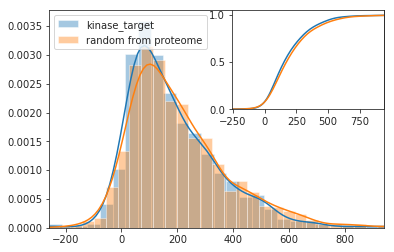

In [42]:
print(np.mean(BF_real_pairs))
print(np.mean(BF_homo_rand_pairs))
fig = plt.figure()

fig.add_subplot(111)
sns.distplot(BF_real_pairs, label='kinase_target')
sns.distplot(BF_homo_rand_pairs, label='random from proteome')
#h = plt.hist(corr_homo_rand, bins=30, alpha=0.4, density=True, label='shuffled_proteome')
plt.xlim(np.percentile(BF_real_pairs,0.1),np.percentile(BF_real_pairs,99.8))
plt.legend(loc='upper left')

fig.add_subplot(222)
sns.kdeplot(BF_real_pairs,cumulative=True)
sns.kdeplot(BF_homo_rand_pairs,cumulative=True)
#h = plt.hist(corr_homo_rand, bins=30, alpha=0.4, density=True, label='shuffled_proteome')
plt.xlim(np.percentile(BF_real_pairs,0.1),np.percentile(BF_real_pairs,99.8))


#plt.savefig('plots/aa_pair_shuffled_null.pdf')

#### amino acid composition

25.21805568007933
22.213451210997988


(-59.615478626730045, 60.5656600834012)

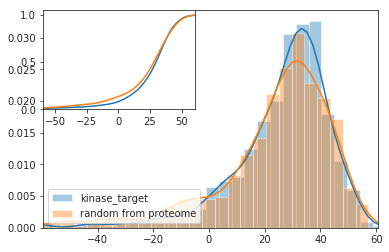

In [43]:
print(np.mean(BF_real))
print(np.mean(BF_homo_rand))
fig = plt.figure()

fig.add_subplot(111)
sns.distplot(BF_real, label='kinase_target')
sns.distplot(BF_homo_rand, label='random from proteome')
plt.xlim(np.percentile(BF_real,1),np.percentile(BF_real,99.95))
plt.legend(loc='lower left')

fig.add_subplot(221)
sns.kdeplot(BF_real,cumulative=True)
sns.kdeplot(BF_homo_rand,cumulative=True)
#h = plt.hist(corr_homo_rand, bins=30, alpha=0.4, density=True, label='shuffled_proteome')
plt.xlim(np.percentile(BF_real,1),np.percentile(BF_real,99.95))

#### amino acid features

3.4924517839398304
2.9234643495142234


(-59.615478626730045, 60.5656600834012)

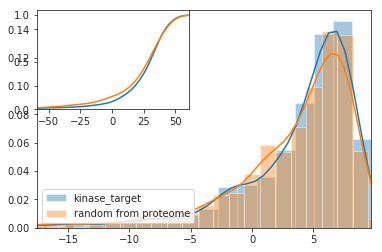

In [44]:
print(np.mean(BF_real_feats))
print(np.mean(BF_homo_rand_feats))
fig = plt.figure()

fig.add_subplot(111)
sns.distplot(BF_real_feats, label='kinase_target')
sns.distplot(BF_homo_rand_feats, label='random from proteome')
plt.legend(loc='lower left')
plt.xlim(np.percentile(BF_real_feats,1),np.percentile(BF_real_feats,99.99))

fig.add_subplot(221)
sns.kdeplot(BF_real,cumulative=True)
sns.kdeplot(BF_homo_rand,cumulative=True)
#h = plt.hist(corr_homo_rand, bins=30, alpha=0.4, density=True, label='shuffled_proteome')

plt.xlim(np.percentile(BF_real,1),np.percentile(BF_real,99.95))

#### combine scores

(-492.98862706446255, 1087.7328090224773)

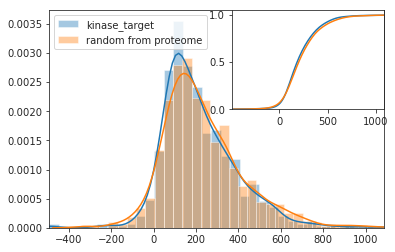

In [45]:
fig = plt.figure()

fig.add_subplot(111)
comb_real = np.array(BF_real)+np.array(BF_real_pairs)+np.array(BF_real_feats)
sns.distplot(comb_real, label='kinase_target')

comb_homo = np.array(BF_homo_rand)+np.array(BF_homo_rand_pairs)+np.array(BF_homo_rand_feats)
sns.distplot(comb_homo, label='random from proteome')
plt.xlim(np.percentile(comb_real,0.1),np.percentile(comb_real,99.95))
plt.legend(loc='upper left')

fig.add_subplot(222)
sns.kdeplot(comb_real, cumulative=True)
sns.kdeplot(comb_homo,cumulative=True)
plt.xlim(np.percentile(comb_real,0.1),np.percentile(comb_real,99.95))
#plt.savefig('plots/comb_scores.pdf')

so there seems to be little information in the mass

## look at candidates with most similarity

In [46]:
#meta_table_reduced.sort_values(by='compo_correlation', ascending=False).to_csv('Kinase_Target_correlation.txt', sep='\t')
#meta_table_reduced.sort_values(by='pair_compo_correlation', ascending=False).to_csv('Kinase_Target_correlation_pairs.txt', sep='\t')
meta_table_reduced.sort_values(by='BF_pair', ascending=False).to_csv('Kinase_CombinedTargets_BF.txt', sep='\t')

In [47]:
meta_table_reduced.sort_values(by='BF_pair', ascending=False)[0:30]

,KINASE,SUBSTRATE,KIN_ORGANISM,kinase_disorder,target_disorder,kinase_length,target_length,compo_correlation,pair_compo_correlation,BF,BF_pair,BF_feat
1717,BCR-ABL1,Bcr,human,mvdpvgfaeawkaqfpdsepprmelrsvgdieqelerckasirrle...,mvdpvgfaeawkaqfpdsepprmelrsvgdieqelerckasirrle...,992,485,NaN,NaN,63.314395,1054.617965,9.189344
6226,WNK3,WNK1,human,matdsgdpastedsekpdgisfenrvpqvaatltvearlkeknstf...,msggaaekqsstpgslflsppapapkngsssdssvgeklgaaaada...,814,1774,NaN,NaN,50.538356,963.080663,6.612874
4842,WNK2,WNK1,human,mdgdggrrdvpgtlmepgrgagpagmaeprakaarpgpqrflrrsv...,msggaaekqsstpgslflsppapapkngsssdssvgeklgaaaada...,1753,1774,NaN,NaN,16.427533,914.212598,9.610387
13402,WNK1,PCF11,human,msggaaekqsstpgslflsppapapkngsssdssvgeklgaaaada...,mseqtpaeagaagaleleqakaqlavslsvqqetsnlgpgsapskl...,1774,1124,NaN,NaN,-7.027865,845.367467,-9.340846
5909,QSK,TORC3,human,maaaaasgaggaagagtggagpagrllpppapgspaapaavspaag...,maaspgsgsanprkfsekialhtqrqaeetrafeqlmtdltlsrvq...,965,619,NaN,NaN,49.051754,796.082661,8.924539
5030,Bcr,Afadin,human,mvdpvgfaeawkaqfpdsepprmelrsvgdieqelerckasirrle...,ddregrfvlknendaippkkaqsngpekqekegviqnfkrtlskke...,485,1037,NaN,NaN,50.270393,726.800980,8.388676
4141,PLK4,PCM-1,human,rrlligqplpnkmtvfpknksstdfsssgdgnsfytqwgnqetsns...,matgggpfedgmndqdlpnwsnenvddrlnnmdwgaqqkkanrsse...,349,1532,NaN,NaN,51.166473,693.994580,1.117689
17680,ULK2,SEC16A,human,sspscrfasppslpdmqhiqeenlsspplgppnylqvskdsastss...,mqpppqtvpsgmagpppagnprsvfwasspyrrrannnaavapttc...,454,1755,NaN,NaN,43.232197,690.084290,6.610852
13583,LATS2,AMOT,human,mrpktfpattysgnsrqrlqeireglkqpskssvqglpagpnsdts...,mrnseeqpsggttvlqrllqeqlrygnpsenrsllaihqqatgngp...,566,816,NaN,NaN,50.541287,689.795185,8.317178
1187,LATS1,INCENP,human,mkrsekpegyrqmrpktfpasnytvssrqmlqeireslrnlskpsd...,mgttapgpihllelcdqklmeflcnmdnkdlvwleeiqeeaermft...,715,854,NaN,NaN,4.431901,675.210925,-6.201278


## Show sequences of a kinase and all its pairs


In [50]:
#target oriented

protein = 'Tau'

tb_sorted = meta_table_reduced.sort_values(by='BF_pair', ascending=False).loc[meta_table_reduced.SUBSTRATE==protein]
headers = [protein] + list(tb_sorted.KINASE.values)
sequences = [tb_sorted.target_disorder.values[0]] + list(tb_sorted.kinase_disorder.values)

In [126]:
#kinase oriented

protein = 'ULK1'

tb_sorted = meta_table_reduced.sort_values(by='BF_pair', ascending=False).loc[meta_table_reduced.KINASE==protein]
headers = [protein] + list(tb_sorted.SUBSTRATE.values)
sequences = [tb_sorted.kinase_disorder.values[0]] + list(tb_sorted.target_disorder.values)

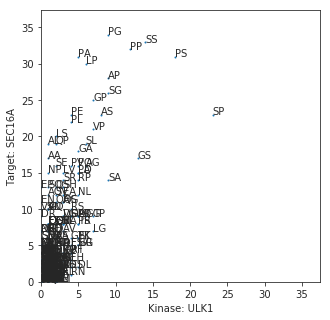

In [127]:
#scatter plot for aa pairs
substrate_no = 1

aa_pairs = []
for aa1 in amino_acids:
    for aa2 in amino_acids:
        aa_pairs.append((aa1+aa2).upper())
        
kinase_frac = count_aa_pair(sequences[0])
target_frac = count_aa_pair(sequences[substrate_no])

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(x=kinase_frac, y=target_frac, s=1)

ax.set_xlim(0,1.1*max(max(kinase_frac),max(target_frac)))
ax.set_ylim(0,1.1*max(max(kinase_frac),max(target_frac)))
ax.set_xlabel('Kinase: ' + headers[0])
ax.set_ylabel('Target: ' + headers[substrate_no])

for i, txt in enumerate(aa_pairs):
    ax.annotate(txt, (kinase_frac[i], target_frac[i]))
    
#plt.scatter(x=kinase_frac, y=target_frac)

In [128]:
interact(display_seq, color_code=['Salma','Lesk', 'RasMol'], sequences=fixed(sequences), headers=fixed(headers))

interactive(children=(Dropdown(description='color_code', options=('Salma', 'Lesk', 'RasMol'), value='Salma'), …

<function __main__.display_seq(sequences, headers, color_code)>

# -----------------------------------
# PLAYGROUND

In [54]:
import networkx as nx
G=nx.Graph()
for i in range(len(meta_table_reduced)):
    G.add_edge(meta_table_reduced.iloc[i,0],meta_table_reduced.iloc[i,1],weight=1)

/home/salma/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


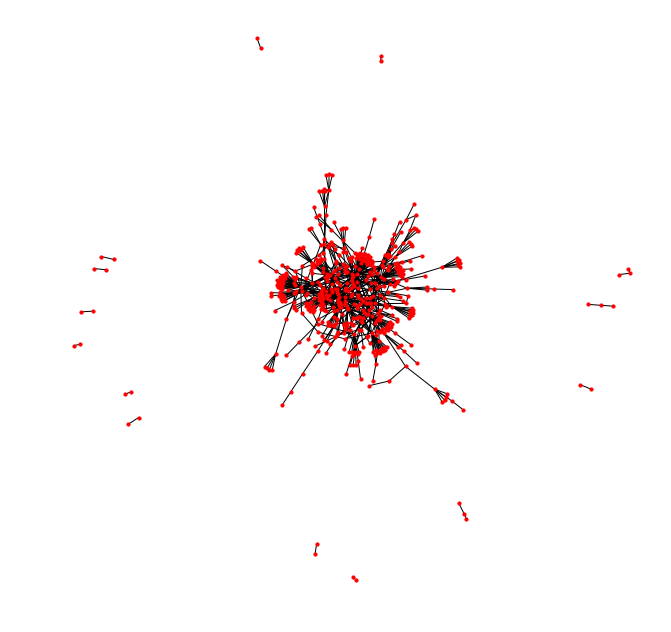

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
node_colors = [G.degree[i] for i in list(G)]
nx.draw_spring(G, node_size=10)
#nx.draw_spring(G, node_size=10, node_color=node_colors, cmap=plt.cm.RdBu_r, vmin=1, vmax=3)
plt.savefig('graph_kinase_phosphatase.pdf')

In [103]:
tb_sorted = meta_table_reduced.sort_values(by='compo_correlation', ascending=False)

In [60]:
i=9
headers = [tb_sorted.iloc[i,0],tb_sorted.iloc[i,3]]
sequences = [tb_sorted.iloc[i,5],tb_sorted.iloc[i,6]]

In [117]:
protein = 'TAU_HUMAN'
#tb_sorted = meta_table_reduced.loc[meta_table_reduced.SUBSTRATE=='TAU_HUMAN']
tb_sorted = meta_table_reduced.loc[meta_table_reduced.SUBSTRATE==protein]
headers = [protein] + list(tb_sorted.KINASE.values)
sequences = [tb_sorted.target_disorder.values[0]] + list(tb_sorted.kinase_disorder.values)

In [169]:
meta_table_reduced = meta_table_reduced.sort_values(by='compo_correlation', ascending=False)
meta_table_reduced.loc[meta_table_reduced.ID=='TAU_HUMAN',:]

,ID,catalytic kinase,target_disorder,kinase_disorder,kinase_length,target_length,compo_correlation
1649,TAU_HUMAN,BRSK2,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,mtyfllldrkerypsqededlpprneidpprkrvdspmlnrhgkrr...,257,758,0.884950
1588,TAU_HUMAN,PKN1,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,mallsaakapdrkavseaqekltesnqklgllrealerrlgelpad...,225,758,0.884821
1591,TAU_HUMAN,GSK3A,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,msgggpsgggpggsgrartssfaepggggggggggpggsasgpggt...,158,758,0.879427
1605,TAU_HUMAN,TTBK1,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,eafdwekagtdallstststppqqntrqtaamfgvvnvtpvpgdll...,1016,758,0.875753
1648,TAU_HUMAN,BRSK1,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,mssgakeggggspayhlphphphppqhaqyvgpyrhepdpclepap...,414,758,0.858380
1592,TAU_HUMAN,MARK1,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,msartplptvnerdtenhtsvdgytephiqptksssrqniprcrns...,411,758,0.831512
1580,TAU_HUMAN,GSK3B,maeprqefevmedhagtyglgdrkdqggytmhqdqegdtdaglkes...,msgrprttsfaesckpvqqpsafgvklpngrdtpalfnfttqelss...,97,758,0.648346


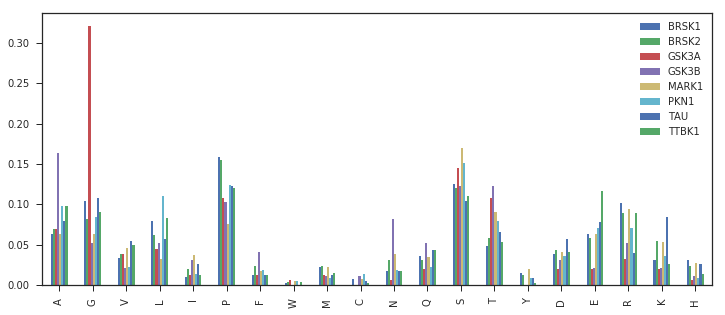

In [197]:
aa_counts = {}
aa_counts['TAU'] = count_aa(tau)
tau_df = meta_table_reduced.loc[meta_table_reduced.ID=='TAU_HUMAN',:]

for i in range(len(tau_df)):
    aa_counts[tau_df.loc[:,'catalytic kinase'].values[i]] = count_aa(tau_df.loc[:,'kinase_disorder'].values[i])

aa_counts = pd.DataFrame(aa_counts)
aa_counts.index = [a.upper() for a in amino_acids]
aa_counts.plot.bar(figsize=(12,5))
plt.savefig(os.path.join('TAU_aa_composition.pdf'))

In [204]:
pair_aa_counts = {}
pair_aa_counts['TAU'] = count_aa_pair(tau)
tau_df = reg_phos_reduced.loc[reg_phos_reduced.ID=='TAU_HUMAN',:]

for i in range(len(tau_df)):
    pair_aa_counts[tau_df.loc[:,'catalytic kinase'].values[i]] = count_aa_pair(tau_df.loc[:,'kinase_disorder'].values[i])

pair_aa_counts = pd.DataFrame(pair_aa_counts)

aa_pairs = []
for aa1 in amino_acids:
    for aa2 in amino_acids:
        aa_pairs.append(aa1+aa2)
        
pair_aa_counts.index = [a.upper() for a in aa_pairs]
pair_aa_counts.plot.bar(figsize=(100,3))
plt.savefig(os.path.join('TAU_aa_composition_pairs.pdf'))
plt.close()

In [96]:
np.mean(reg_phos_reduced.loc[reg_phos_reduced.ID=='TAU_HUMAN',:].compo_correlation.values)

0.83759836423462009

In [91]:
corr_tau = []
for kiseq in reg_phos_reduced.kinase_disorder.unique():
    corr_tau.append(stats.spearmanr(count_aa(tau),count_aa(kiseq))[0])

In [52]:
#count motifs within a sequence

countables = ['FG', 'SR', 'RG', 'F', 'R']

for c in countables:
    kinome[c] = [x.count(c.lower()) for x in kinome.sequence.values]
    kinome[c+'_freq'] = kinome.loc[:,c]/kinome.loc[:,'length']
    
kinome['aromats'] = np.array([x.count('F'.lower()) for x in kinome.sequence.values]) + np.array([x.count('Y'.lower()) for x in kinome.sequence.values]) + np.array([x.count('W'.lower()) for x in kinome.sequence.values])
kinome['aromats_freq'] = kinome.loc[:,'aromats']/kinome.loc[:,'length']

In [125]:
reg_phos_reduced

,ID,catalytic kinase,target_disorder,kinase_disorder,kinase_length,target_length,compo_correlation
4708,FAK1_HUMAN,PTK2,maaayldpnlnhtpnsstkthlgtgmkegeralpsipklansekqg...,kegeralpsipklansekqgmrthavsvsetddyaeiideedtytm...,314,340,0.981516
3769,PAXI_HUMAN,FAK,mddldalladlesttshiskrpvflseetpysyptgnhtyqeiavp...,maaayldpnlnhtpnsstkthlgtgmkegeralpsipklansekqg...,340,341,0.971636
5904,HDAC7_HUMAN,PKD1,mdlrvgqrppvepppeptllalqrpqrlhhhlflaglqqqrsvepm...,dliqqvlaegvsspaptqdthmetdllsslsstpgektetlalqrl...,199,527,0.946260
3770,PAXI_HUMAN,PTK2,mddldalladlesttshiskrpvflseetpysyptgnhtyqeiavp...,kegeralpsipklansekqgmrthavsvsetddyaeiideedtytm...,314,341,0.938756
2767,MOES_HUMAN,ROCK2,kpdtievqqmkaqareekhqkqmeramlenekkkremaekekekie...,msrppptgkmpgapetapgdgagasrqrklealscretdsiqsrkn...,551,282,0.932153
3014,MPIP2_HUMAN,BRSK1,mevpqpepapgsalspagvcggaqrpghlpglllgshgllgspvra...,mssgakeggggspayhlphphphppqhaqyvgpyrhepdpclepap...,414,376,0.918644
569,OXSR1_HUMAN,Wnk1,qektlqraptiserakkvrrvpgssgrlhktedggwewsddefdee...,msggaaekqsstpgslflsppapapkngsssdssvgeklgaaaada...,1774,135,0.903225
6012,ARHG2_HUMAN,PAK4,msriesltraridrsrelasktrekekmkeakdarytgvellltpr...,mfgkrkkrveisapsnfehrvhtgfdqheqkftglprqwqsliees...,315,351,0.897736
2773,MOES_HUMAN,ROCK1,kpdtievqqmkaqareekhqkqmeramlenekkkremaekekekie...,rrylssanpndnrtssnadkslqeslqktiykleeqlhnemqlkde...,600,282,0.895967
634,ABL1_HUMAN,SRC,qafetmfqessisdevekelgkqgvrgavstllqapelptktrtsr...,mgsnkskpkdasqrrrslepaenvhgagggafpasqtpskpasadg...,79,525,0.888978


In [156]:
np.exp(loggamma(5+1))

119.99999999999997